# SEDD for Perturbation-Seq Prediction
**Input**: Control cell expression + Perturbation label  
**Output**: Predicted perturbed cell expression

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


## 1. Load Real Perturbation-Seq Data with Cell-Load

We'll use the [cell-load](https://github.com/ArcInstitute/cell-load) package to load real perturbation-seq data:
- HepG2 cell line with gene knockouts
- Control cells (non-targeting)
- Multiple perturbations with cell-specific effects

In [3]:
# Import cell-load for perturbation data loading
from cell_load.data_modules import PerturbationDataModule
import scanpy as sc
import os

# Load and inspect the data first
pseq_datapath = "/home/b5cc/sanjukta.b5cc/st3/datasets/competition_support_set/hepg2.h5"
adata = sc.read(pseq_datapath)

print(f'=== HepG2 Perturbation Dataset ===')
print(f'Expression shape: {adata.shape}')
print(f'Number of cells: {adata.n_obs}')
print(f'Number of genes: {adata.n_vars}')

# Examine perturbations
print(f'\n=== Perturbation Information ===')
pert_counts = adata.obs['gene'].value_counts()
print(f'Total perturbations: {len(pert_counts)}')
print(f'Control cells (non-targeting): {pert_counts.get("non-targeting", 0)}')
print(f'Perturbed cells: {adata.n_obs - pert_counts.get("non-targeting", 0)}')

print(f'\nTop 10 perturbations:')
for pert, count in pert_counts.head(10).items():
    print(f'  {pert}: {count} cells')

# Cell type and batch info
print(f'\n=== Additional Metadata ===')
print(f'Cell types: {adata.obs["cell_type"].unique()}')
print(f'Number of batches (gem_group): {adata.obs["gem_group"].nunique()}')

# Expression data characteristics
print(f'\n=== Expression Data ===')
print(f'Expression matrix type: {type(adata.X)}')
print(f'Data range: {adata.X.min():.2f} to {adata.X.max():.2f}')
print(f'Sparsity (zeros): {(adata.X == 0).sum() / adata.X.size:.2%}')

# cell-load requires embeddings in obsm, so we copy X to obsm
print(f'\n=== Preparing data for cell-load ===')
adata.obsm['X_expr'] = adata.X.copy()
print(f'Added expression matrix to obsm as "X_expr": {adata.obsm["X_expr"].shape}')

# Save the modified data to a new location for cell-load
cellload_data_dir = "/home/b5cc/sanjukta.b5cc/st3/datasets/cellload_hepg2"
os.makedirs(cellload_data_dir, exist_ok=True)
cellload_path = os.path.join(cellload_data_dir, "hepg2.h5ad")
adata.write_h5ad(cellload_path)
print(f'Saved cell-load compatible data to: {cellload_path}')

=== HepG2 Perturbation Dataset ===
Expression shape: (9386, 18080)
Number of cells: 9386
Number of genes: 18080

=== Perturbation Information ===
Total perturbations: 69
Control cells (non-targeting): 4976
Perturbed cells: 4410

Top 10 perturbations:
  non-targeting: 4976 cells
  TFAM: 1213 cells
  EIF4B: 217 cells
  JAZF1: 153 cells
  TAF13: 134 cells
  HIRA: 129 cells
  MBTPS1: 115 cells
  MAT2A: 104 cells
  ARPC2: 99 cells
  DNMT1: 82 cells

=== Additional Metadata ===
Cell types: ['hepg2']
Categories (1, object): ['hepg2']
Number of batches (gem_group): 56

=== Expression Data ===
Expression matrix type: <class 'numpy.ndarray'>
Data range: 0.00 to 7.71
Sparsity (zeros): 78.49%

=== Preparing data for cell-load ===
Added expression matrix to obsm as "X_expr": (9386, 18080)
Saved cell-load compatible data to: /home/b5cc/sanjukta.b5cc/st3/datasets/cellload_hepg2/hepg2.h5ad


In [4]:
# Create Cell-Load DataModule
print('=== Setting up Cell-Load DataModule ===')

# Create the PerturbationDataModule using our TOML config
dm = PerturbationDataModule(
    toml_config_path="../cell_load_config.toml",
    embed_key="X_expr",                # Use the expression matrix we saved to obsm
    output_space="embedding",          # Use embeddings only (avoids X_hvg lookup)
    num_workers=0,                     # Use 0 for debugging
    batch_size=32,
    pert_col="gene",
    cell_type_key="cell_type",
    batch_col="gem_group", 
    control_pert="non-targeting",
    
    # Optional parameters
    barcode=True,
    basal_mapping_strategy="random",
    n_basal_samples=1,
    should_yield_control_cells=True,
)

# Setup the data module
dm.setup()
print(f'DataModule setup complete!')

# Get some basic info about the loaded data
print(f'\n=== DataModule Information ===')
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')

# Inspect a batch
sample_batch = next(iter(train_loader))
print(f'\n=== Sample Batch Structure ===')
for key, value in sample_batch.items():
    if hasattr(value, 'shape'):
        print(f'{key}: shape={value.shape}, dtype={value.dtype}')
    else:
        print(f'{key}: {type(value)} - sample: {value[:3] if hasattr(value, "__getitem__") else value}')

=== Setting up Cell-Load DataModule ===
/home/b5cc/sanjukta.b5cc/st3/datasets/cellload_hepg2


Processing hepg2_data: 100%|██████████| 1/1 [00:00<00:00, 26.08it/s]

Processed hepg2: 9386 train, 0 val, 0 test
DataModule setup complete!

=== DataModule Information ===
Training batches: 3
Validation batches: 0



=== Sample Batch Structure ===
pert_cell_emb: shape=torch.Size([16384, 18080]), dtype=torch.float32
ctrl_cell_emb: shape=torch.Size([16384, 18080]), dtype=torch.float32
pert_emb: shape=torch.Size([16384, 69]), dtype=torch.float32
pert_name: <class 'list'> - sample: [np.str_('DNMT1'), np.str_('DNMT1'), np.str_('DNMT1')]
cell_type: <class 'list'> - sample: [np.str_('hepg2'), np.str_('hepg2'), np.str_('hepg2')]
cell_type_onehot: shape=torch.Size([16384, 1]), dtype=torch.float32
batch: shape=torch.Size([16384, 56]), dtype=torch.float32
batch_name: <class 'list'> - sample: [np.str_('44'), np.str_('43'), np.str_('38')]
pert_cell_barcode: <class 'list'> - sample: [np.str_('cell_001804'), np.str_('cell_007903'), np.str_('cell_005947')]
ctrl_cell_barcode: <class 'list'> - sample: [np.str_('cell_001696'), np.str_('cell_000366'), np.str_('cell_004190')]


In [5]:
# Let's examine the structure of the h5ad file
import scanpy as sc
import pandas as pd

print("=== Examining h5ad file structure ===")
print(f"Shape: {adata.shape}")
print(f"Number of observations (cells): {adata.n_obs}")
print(f"Number of variables (genes): {adata.n_vars}")

print("\n=== Observation metadata (adata.obs) ===")
print("Columns:", list(adata.obs.columns))
print(adata.obs.head())

print("\n=== Variable metadata (adata.var) ===")
print("Columns:", list(adata.var.columns))
print(adata.var.head())

print("\n=== Available obsm keys (embeddings) ===")
print("Keys:", list(adata.obsm.keys()))

print("\n=== Expression data ===")
print(f"X shape: {adata.X.shape}")
print(f"X type: {type(adata.X)}")

# Check if there are perturbation-related columns
print("\n=== Looking for perturbation-related columns ===")
pert_cols = [col for col in adata.obs.columns if 'pert' in col.lower() or 'gene' in col.lower() or 'treat' in col.lower()]
print(f"Potential perturbation columns: {pert_cols}")

for col in pert_cols[:3]:  # Show first 3 columns
    print(f"\n{col} unique values:", adata.obs[col].unique()[:10])  # Show first 10 unique values


=== Examining h5ad file structure ===
Shape: (9386, 18080)
Number of observations (cells): 9386
Number of variables (genes): 18080

=== Observation metadata (adata.obs) ===
Columns: ['gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'batch_var', 'target_gene', 'cell_type']
                     gem_group           gene          gene_id     transcript  \
cell_barcode                                                                    
AAACCCAAGACGCCCT-39         39          PHF10  ENSG00000130024           P1P2   
AAACCCAAGATGGCAC-43         43           TFAM  ENSG00000108064           P1P2   
AAACCCAAGCTGGAGT-49         49  non-targeting    non-targeting  non-targeting   
AAACCCAAGGTCGTCC-18         18           TFAM  ENSG00000108064           P1P2   
AAACCCAAGTCGCTAT-20         20          PTPN1  ENSG00000196396           P1P2   

                                                     gene_transcript  \
cell_barcode  

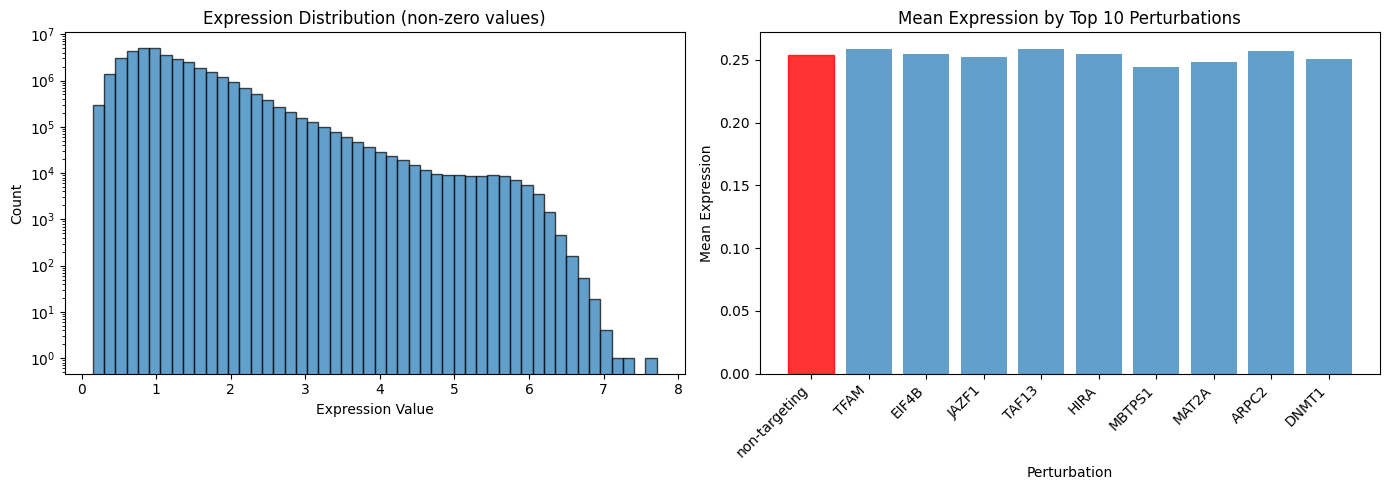

Expression statistics:
  Mean: 0.25
  Std: 0.57
  Non-zero values: 36,509,861 (21.5%)


In [6]:
# Visualize real expression data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Expression value distribution
expression_data = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
non_zero_expr = expression_data[expression_data > 0]

axes[0].hist(non_zero_expr.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Expression Value')
axes[0].set_ylabel('Count')
axes[0].set_title('Expression Distribution (non-zero values)')
axes[0].set_yscale('log')  # Log scale for better visualization

# Mean expression per perturbation (top 10)
pert_counts = adata.obs['gene'].value_counts()
top_perts = pert_counts.head(10).index.tolist()

pert_means = []
pert_labels = []
for pert in top_perts:
    mask = adata.obs['gene'] == pert
    pert_expr = expression_data[mask.values]
    pert_means.append(pert_expr.mean())
    pert_labels.append(pert)

bars = axes[1].bar(range(len(pert_labels)), pert_means, alpha=0.7)
axes[1].set_xticks(range(len(pert_labels)))
axes[1].set_xticklabels(pert_labels, rotation=45, ha='right')
axes[1].set_xlabel('Perturbation')
axes[1].set_ylabel('Mean Expression')
axes[1].set_title('Mean Expression by Top 10 Perturbations')

# Color the control bar differently
for i, label in enumerate(pert_labels):
    if label == 'non-targeting':
        bars[i].set_color('red')
        bars[i].set_alpha(0.8)

plt.tight_layout()
plt.show()

print(f'Expression statistics:')
print(f'  Mean: {expression_data.mean():.2f}')
print(f'  Std: {expression_data.std():.2f}')
print(f'  Non-zero values: {(expression_data > 0).sum():,} ({(expression_data > 0).mean():.1%})')

## 2. Examine Cell-Load Data Format

Cell-load provides structured batches with control-perturbed cell pairs and perturbation labels.
Let's examine the data format and adapt it for our training pipeline.

In [ ]:
# Examine cell-load batch structure and create adapter
import torch
from torch.utils.data import Dataset

# Get a sample batch to understand the structure
sample_batch = next(iter(train_loader))
print("=== Cell-Load Batch Structure ===")
for key, value in sample_batch.items():
    if hasattr(value, 'shape'):
        print(f'{key}: shape={value.shape}, dtype={value.dtype}')
    else:
        print(f'{key}: {type(value)}')

print("\n=== Examining batch contents ===")
print(f"Batch size: {sample_batch['pert_cell_emb'].shape[0]}")
print(f"Number of genes: {sample_batch['pert_cell_emb'].shape[1]}")

# Extract perturbation names to create mapping
pert_names = list(set(sample_batch['pert_name']))
print(f"Perturbations in batch: {pert_names}")

# Count total unique perturbations in dataset
all_pert_names = set()
max_expr_value = 0
for batch in train_loader:
    all_pert_names.update(batch['pert_name'])
    # Track max expression value for vocabulary size
    max_expr_value = max(max_expr_value, batch['pert_cell_emb'].max().item())
    max_expr_value = max(max_expr_value, batch['ctrl_cell_emb'].max().item())
for batch in val_loader:
    all_pert_names.update(batch['pert_name'])
    max_expr_value = max(max_expr_value, batch['pert_cell_emb'].max().item())
    max_expr_value = max(max_expr_value, batch['ctrl_cell_emb'].max().item())

print(f"Total unique perturbations: {len(all_pert_names)}")
print(f"Sample perturbations: {list(all_pert_names)[:10]}")
print(f"Max expression value in dataset: {max_expr_value:.2f}")

# Create perturbation name to index mapping
pert_to_idx = {name: idx for idx, name in enumerate(sorted(all_pert_names))}
print(f"Perturbation mapping (first 5): {dict(list(pert_to_idx.items())[:5])}")

# Set parameters for the model based on real data
NUM_GENES = sample_batch['pert_cell_emb'].shape[1]  # 18080 genes
NUM_PERTURBATIONS = len(all_pert_names)  # Number of unique perturbations

# NUM_BINS: number of discrete expression bins (excluding mask token)
# Since we use raw transcripts with max value ~7.71, we need bins 0-7 (8 bins total)
NUM_BINS = int(max_expr_value) + 1  # 0, 1, 2, 3, 4, 5, 6, 7 = 8 bins
VOCAB_SIZE = NUM_BINS + 1  # +1 for mask token

print(f"\n=== Model Parameters ===")
print(f"NUM_GENES: {NUM_GENES}")
print(f"NUM_PERTURBATIONS: {NUM_PERTURBATIONS}")
print(f"NUM_BINS: {NUM_BINS} (discrete expression bins)")
print(f"VOCAB_SIZE: {VOCAB_SIZE} (bins + mask token)")

Sample from cell-load batch:
  Control shape: torch.Size([18080])
  Perturbed shape: torch.Size([18080])
  Perturbation: DNMT1
  Control range: 0.00-6.29
  Perturbed range: 0.00-6.22


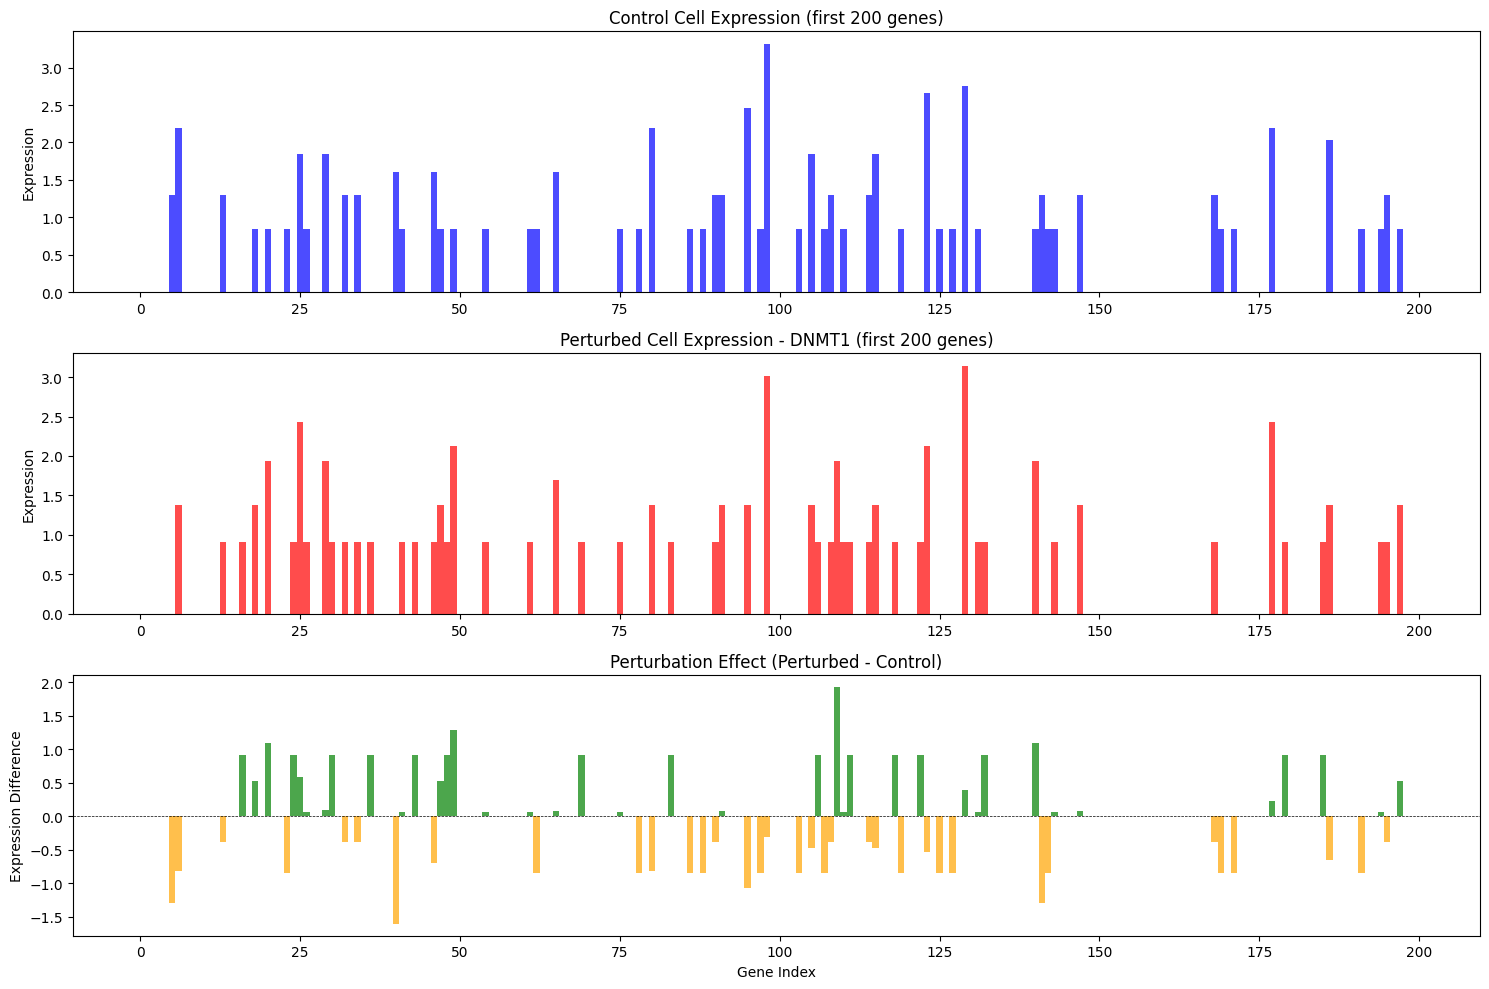


Expression statistics:
  Control mean: 0.23, std: 0.55
  Perturbed mean: 0.22, std: 0.55
  Mean difference: -0.0111
  Genes with >10% change: 3866


In [8]:
# Visualize cell-load data format - control vs perturbed cells (using raw expression values)
sample_batch = next(iter(train_loader))

# Get first cell from batch
control_cell = sample_batch['ctrl_cell_emb'][0].cpu()
perturbed_cell = sample_batch['pert_cell_emb'][0].cpu() 
pert_name = sample_batch['pert_name'][0]

print(f'Sample from cell-load batch:')
print(f'  Control shape: {control_cell.shape}')
print(f'  Perturbed shape: {perturbed_cell.shape}')
print(f'  Perturbation: {pert_name}')
print(f'  Control range: {control_cell.min():.2f}-{control_cell.max():.2f}')
print(f'  Perturbed range: {perturbed_cell.min():.2f}-{perturbed_cell.max():.2f}')

# Visualize a subset of genes for clarity (first 200 genes)
n_genes_viz = min(200, NUM_GENES)
gene_indices = np.arange(n_genes_viz)

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Control cell (raw expression)
axes[0].bar(gene_indices, control_cell[:n_genes_viz].numpy(), alpha=0.7, width=1.0, color='blue')
axes[0].set_ylabel('Expression')
axes[0].set_title(f'Control Cell Expression (first {n_genes_viz} genes)')

# Perturbed cell (raw expression)
axes[1].bar(gene_indices, perturbed_cell[:n_genes_viz].numpy(), alpha=0.7, width=1.0, color='red')
axes[1].set_ylabel('Expression')
axes[1].set_title(f'Perturbed Cell Expression - {pert_name} (first {n_genes_viz} genes)')

# Difference
diff = (perturbed_cell - control_cell)[:n_genes_viz].numpy()
colors = ['green' if d > 0 else 'orange' if d < 0 else 'gray' for d in diff]
axes[2].bar(gene_indices, diff, alpha=0.7, width=1.0, color=colors)
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_xlabel('Gene Index')
axes[2].set_ylabel('Expression Difference')
axes[2].set_title(f'Perturbation Effect (Perturbed - Control)')

plt.tight_layout()
plt.show()

# Show statistics
print(f'\nExpression statistics:')
print(f'  Control mean: {control_cell.mean():.2f}, std: {control_cell.std():.2f}')
print(f'  Perturbed mean: {perturbed_cell.mean():.2f}, std: {perturbed_cell.std():.2f}')
print(f'  Mean difference: {(perturbed_cell - control_cell).mean():.4f}')
print(f'  Genes with >10% change: {(torch.abs(perturbed_cell - control_cell) > 0.1 * control_cell).sum().item()}')

In [9]:
# Cell-load already provides train/val dataloaders
# We need to create an adapter to convert cell-load batches to the format expected by our model

print('=== DataLoader Information ===')
print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')

def convert_cellload_batch(batch, pert_to_idx):
    """
    Convert cell-load batch format to format expected by SEDD model
    
    Input (cell-load): 
        - pert_cell_emb: perturbed cell embeddings [batch, genes]
        - ctrl_cell_emb: control cell embeddings [batch, genes]  
        - pert_name: perturbation names [batch]
        
    Output (SEDD format):
        - control: raw control expression as long tensor [batch, genes]
        - pert_label: perturbation indices [batch] 
        - perturbed: raw perturbed expression as long tensor [batch, genes]
    """
    # Extract data from batch
    pert_cell_emb = batch['pert_cell_emb']  # [batch, genes]
    ctrl_cell_emb = batch['ctrl_cell_emb']  # [batch, genes]
    pert_names = batch['pert_name']         # [batch] list of strings
    
    # Convert perturbation names to indices
    pert_labels = torch.tensor([pert_to_idx[name] for name in pert_names])
    
    # Use raw expression values directly (cast to long for discrete model)
    # Round to nearest integer for discrete tokens
    control = torch.round(ctrl_cell_emb).long()
    perturbed = torch.round(pert_cell_emb).long()
    
    return control, pert_labels, perturbed

# Test the conversion
sample_batch = next(iter(train_loader))
control, pert_labels, perturbed = convert_cellload_batch(sample_batch, pert_to_idx)

print(f'\n=== Converted Batch Format ===')
print(f'Control shape: {control.shape}, dtype: {control.dtype}')
print(f'Pert labels shape: {pert_labels.shape}, dtype: {pert_labels.dtype}')  
print(f'Perturbed shape: {perturbed.shape}, dtype: {perturbed.dtype}')
print(f'Pert label range: {pert_labels.min()}-{pert_labels.max()}')
print(f'Expression value range: {control.min()}-{control.max()}')

=== DataLoader Information ===
Training batches: 3
Validation batches: 0

=== Converted Batch Format ===
Control shape: torch.Size([16384, 18080]), dtype: torch.int64
Pert labels shape: torch.Size([16384]), dtype: torch.int64
Perturbed shape: torch.Size([16384, 18080]), dtype: torch.int64
Pert label range: 4-68
Expression value range: 0-7


## 3. Create Perturbation Prediction Model

We use `SEDDPerturbationTransformer` which conditions on perturbation labels.

In [ ]:
from sedd.model import SEDDPerturbationTransformerSmall
from sedd.graph import AbsorbingGraph
from sedd.noise import LogLinearNoise

print(f'=== Model Configuration ===')
print(f'  Genes: {NUM_GENES}')
print(f'  Bins: {NUM_BINS}')
print(f'  Perturbations: {NUM_PERTURBATIONS}')
print(f'  Vocabulary size: {VOCAB_SIZE}')

# Create model with perturbation conditioning
model = SEDDPerturbationTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    num_perturbations=NUM_PERTURBATIONS,
    hidden_dim=128,
    num_layers=4,
    num_heads=4,
    dropout=0.1
).to(device)

# Diffusion components
graph = AbsorbingGraph(num_states=VOCAB_SIZE)
noise = LogLinearNoise(eps=1e-3)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'\n=== Model Details ===')
print(f'Model parameters: {num_params:,}')
print(f'Model device: {next(model.parameters()).device}')

## 4. Train the Model

Training objective: Predict perturbed cell from masked perturbed cell + perturbation label

In [ ]:
from sedd.trainer import PerturbationTrainer

# Create trainer
trainer = PerturbationTrainer(
    model=model,
    graph=graph,
    noise=noise,
    device=device,
    gradient_clip=1.0
)

print('Trainer created successfully!')

Trainer created successfully!


In [ ]:
# Create adapter dataloaders that convert cell-load format to SEDD format
class CellLoadAdapter:
    def __init__(self, dataloader, pert_to_idx):
        self.dataloader = dataloader
        self.pert_to_idx = pert_to_idx
        
    def __iter__(self):
        for batch in self.dataloader:
            control, pert_labels, perturbed = convert_cellload_batch(
                batch, self.pert_to_idx
            )
            # Yield in the format expected by SEDD trainer: (control, pert_label, perturbed)
            for i in range(control.shape[0]):
                yield (control[i], pert_labels[i], perturbed[i])
    
    def __len__(self):
        # Approximate length (batch_size * num_batches)
        return len(self.dataloader) * 32  # Assuming batch size of 32

# Create adapted dataloaders
adapted_train_loader = CellLoadAdapter(train_loader, pert_to_idx) 
adapted_val_loader = CellLoadAdapter(val_loader, pert_to_idx)

print('=== Adapted DataLoaders ===')
print(f'Adapted train loader length: ~{len(adapted_train_loader)}')
print(f'Adapted val loader length: ~{len(adapted_val_loader)}')

# Test the adapted loader
sample_item = next(iter(adapted_train_loader))
control, pert_label, perturbed = sample_item
print(f'\nSample from adapted loader:')
print(f'  Control shape: {control.shape}, dtype: {control.dtype}')
print(f'  Pert label: {pert_label.item()}, dtype: {pert_label.dtype}')
print(f'  Perturbed shape: {perturbed.shape}, dtype: {perturbed.dtype}')

# Train for a few epochs (use more epochs for better results)
NUM_EPOCHS = 2
MASK_RATIO = 0.15  # Fraction of genes to mask during training

print(f'\n=== Training Configuration ===')
print(f'Epochs: {NUM_EPOCHS}')
print(f'Mask ratio: {MASK_RATIO}')

history = trainer.train(
    train_loader=adapted_train_loader,
    val_loader=adapted_val_loader,
    num_epochs=NUM_EPOCHS,
    mask_ratio=MASK_RATIO,
    log_interval=1,
    val_interval=1
)

print('\nTraining complete!')

Epoch 1/2: 100%|██████████| 14/14 [01:50<00:00,  7.91s/it, loss=4.5016]


Epoch 1: train_loss=4.5705, val_loss=4.4904


Epoch 2/2: 100%|██████████| 14/14 [01:22<00:00,  5.92s/it, loss=4.1342]


Epoch 2: train_loss=4.3362, val_loss=4.0825

Training complete!


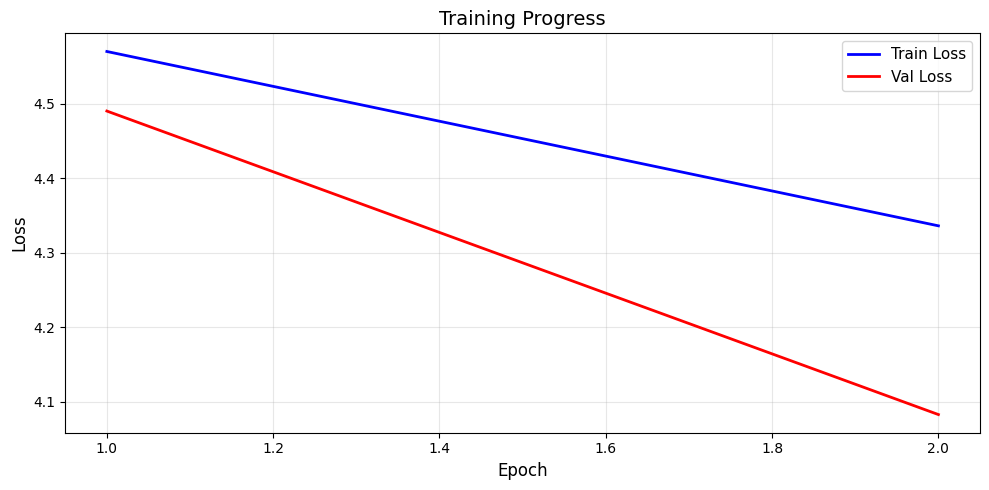

Final train loss: 4.3362
Final val loss: 4.0825
Best val loss: 4.0825


In [ ]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

epochs = range(1, len(history['train_loss']) + 1)
ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Progress', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Final train loss: {history["train_loss"][-1]:.4f}')
print(f'Final val loss: {history["val_loss"][-1]:.4f}')
print(f'Best val loss: {trainer.best_loss:.4f}')

## 5. Inference: Predict Perturbed Cells

Now we test the model's ability to predict how cells respond to perturbations.

In [ ]:
from sedd.sampling import EulerSampler

# Set model to eval mode
model.eval()

# Get a test batch from the adapted train loader (since val_loader is empty)
# Collect a batch of samples for testing
test_samples = []
for i, sample in enumerate(adapted_train_loader):
    test_samples.append(sample)
    if i >= 31:  # Collect 32 samples
        break

# Stack samples into batches
test_control = torch.stack([s[0] for s in test_samples])
test_pert_labels = torch.stack([s[1] for s in test_samples])
test_perturbed = torch.stack([s[2] for s in test_samples])

test_control = test_control.to(device)
test_pert_labels = test_pert_labels.to(device)
test_perturbed = test_perturbed.to(device)

print(f'Test batch:')
print(f'  Controls: {test_control.shape}')
print(f'  Pert labels: {test_pert_labels.shape}')
print(f'  True perturbed: {test_perturbed.shape}')

In [ ]:
# Predict perturbed cells using sampling
# We start from all-masked and condition on perturbation labels

with torch.no_grad():
    # Create sampler
    sampler = EulerSampler(
        model=model,
        graph=graph,
        noise=noise,
        num_steps=50,
        device=device,
        temperature=1.0
    )
    
    # Start from all masked
    batch_size = test_control.shape[0]
    x_init = torch.full((batch_size, NUM_GENES), graph.mask_index, device=device)
    
    # Sample with perturbation conditioning
    # Note: Current sampler doesn't take pert_labels, so we'll use a simpler approach
    # For full implementation, we'd need to modify the sampler
    
    # Simple prediction: forward pass with low noise
    sigma = torch.ones(batch_size, device=device) * 0.01
    logits = model(x_init, sigma, test_pert_labels)
    predicted = logits.argmax(dim=-1)

print(f'Predicted perturbed cells: {predicted.shape}')

Predicted perturbed cells: torch.Size([32, 200])


In [ ]:
# Evaluate predictions
with torch.no_grad():
    # Exact match accuracy
    accuracy = (predicted == test_perturbed).float().mean().item()
    print(f'Exact match accuracy: {accuracy:.2%}')
    
    # Mean absolute error
    mae = (predicted - test_perturbed).abs().float().mean().item()
    print(f'Mean Absolute Error: {mae:.2f}')
    
    # Within-k accuracy
    for k in [1, 3, 5, 10]:
        within_k = ((predicted - test_perturbed).abs() <= k).float().mean().item()
        print(f'Within {k}: {within_k:.2%}')
    

Exact match accuracy: 71.23%
Mean Absolute Error: 21.37 bins
Within 1 bins: 71.23%
Within 3 bins: 71.23%
Within 5 bins: 71.23%
Within 10 bins: 71.23%

Average per-gene correlation: 0.000


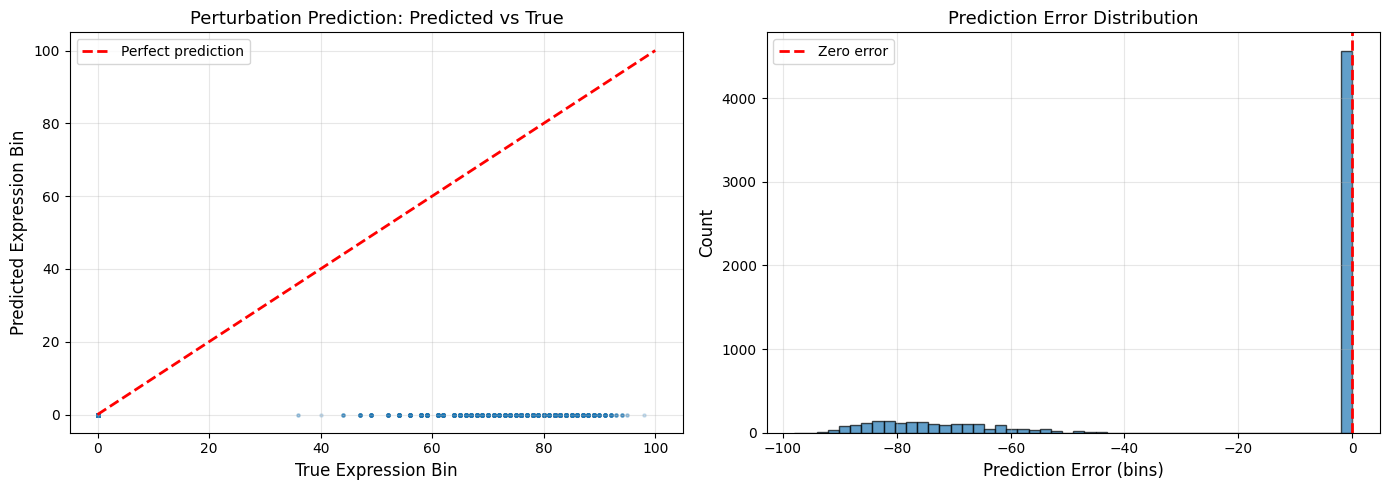

In [ ]:
# Visualize predictions vs ground truth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
true_flat = test_perturbed.cpu().numpy().flatten()
pred_flat = predicted.cpu().numpy().flatten()
max_val = max(true_flat.max(), pred_flat.max())

axes[0].scatter(true_flat, pred_flat, alpha=0.2, s=5)
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('True Expression', fontsize=12)
axes[0].set_ylabel('Predicted Expression', fontsize=12)
axes[0].set_title('Perturbation Prediction: Predicted vs True', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = (pred_flat - true_flat)
axes[1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Prediction Error', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Prediction Error Distribution', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Example Predictions

Let's look at individual cell predictions in detail.

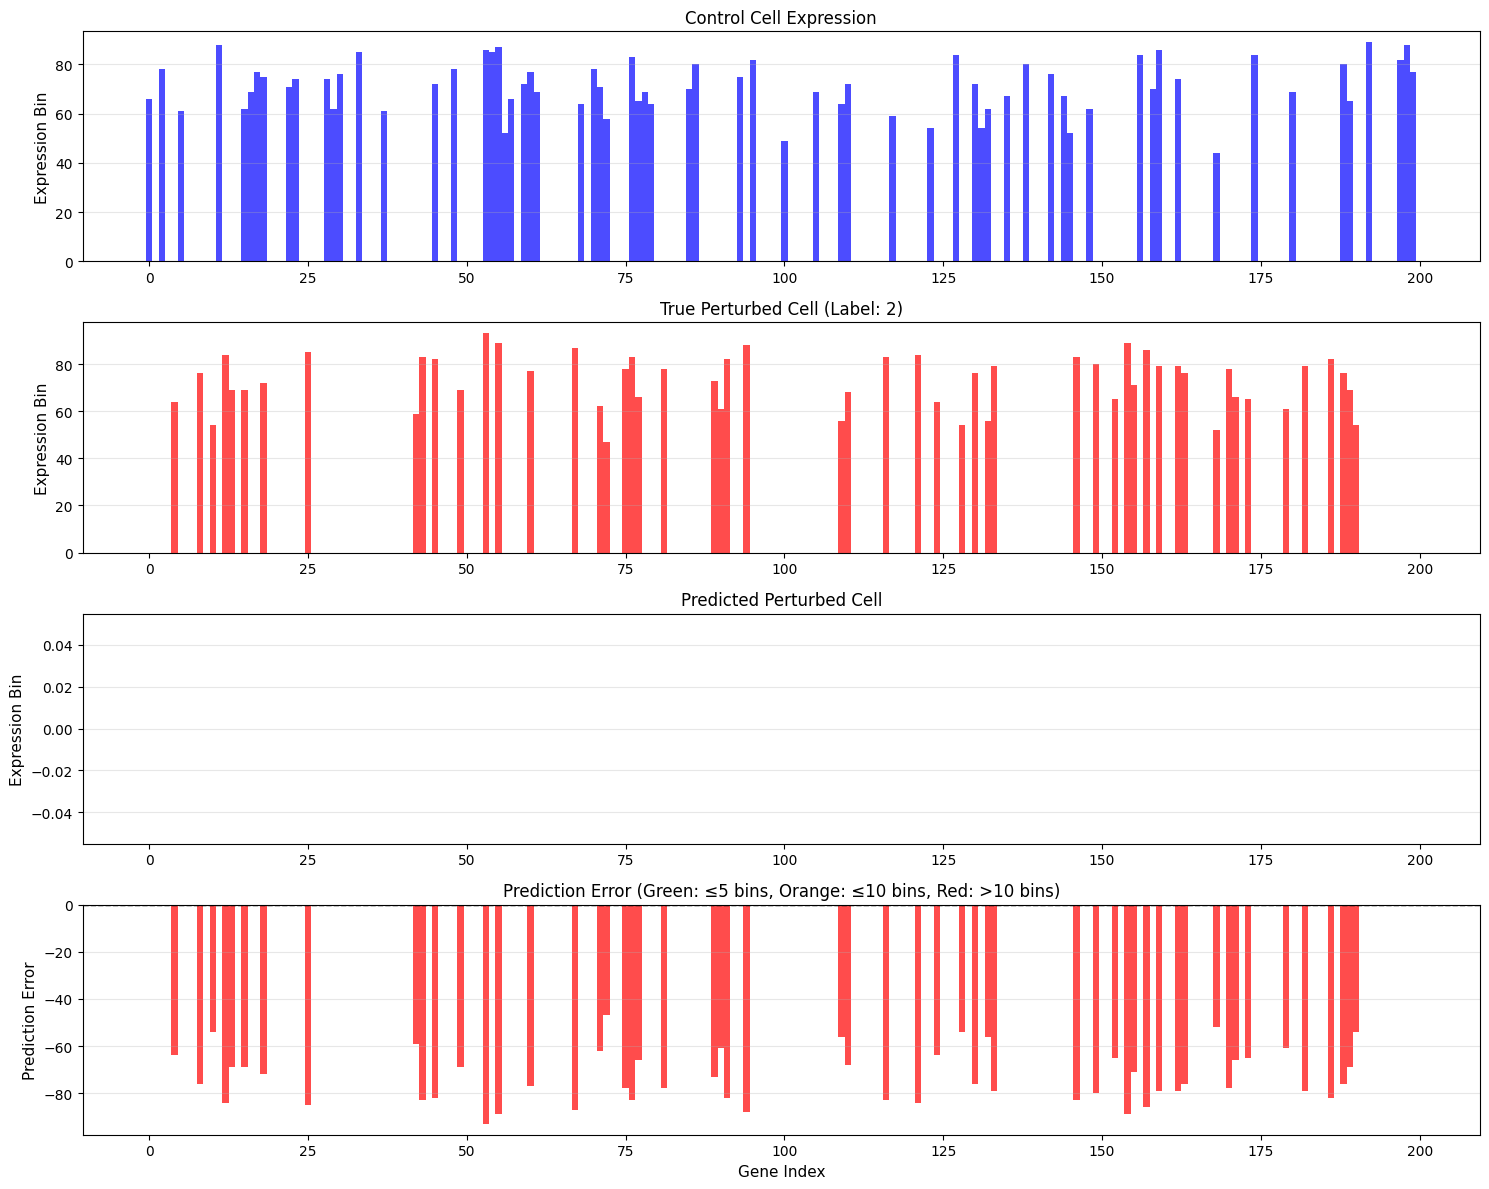


Cell 0 metrics:
  Accuracy: 73.00%
  MAE: 19.70 bins


In [ ]:
# Visualize individual predictions
cell_idx = 0

control_cell = test_control[cell_idx].cpu().numpy()
true_perturbed = test_perturbed[cell_idx].cpu().numpy()
pred_perturbed = predicted[cell_idx].cpu().numpy()
pert_label = test_pert_labels[cell_idx].item()

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

gene_indices = np.arange(NUM_GENES)

# Control
axes[0].bar(gene_indices, control_cell, alpha=0.7, width=1.0, color='blue')
axes[0].set_ylabel('Expression', fontsize=11)
axes[0].set_title(f'Control Cell Expression', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# True perturbed
axes[1].bar(gene_indices, true_perturbed, alpha=0.7, width=1.0, color='red')
axes[1].set_ylabel('Expression', fontsize=11)
axes[1].set_title(f'True Perturbed Cell (Label: {pert_label})', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Predicted perturbed
axes[2].bar(gene_indices, pred_perturbed, alpha=0.7, width=1.0, color='green')
axes[2].set_ylabel('Expression', fontsize=11)
axes[2].set_title(f'Predicted Perturbed Cell', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

# Prediction error
error = pred_perturbed - true_perturbed
colors = ['green' if abs(e) <= 5 else 'orange' if abs(e) <= 10 else 'red' for e in error]
axes[3].bar(gene_indices, error, alpha=0.7, width=1.0, color=colors)
axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
axes[3].set_xlabel('Gene Index', fontsize=11)
axes[3].set_ylabel('Prediction Error', fontsize=11)
axes[3].set_title('Prediction Error (Green: ≤5, Orange: ≤10, Red: >10)', fontsize=12)
axes[3].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate metrics for this cell
cell_acc = (true_perturbed == pred_perturbed).mean()
cell_mae = np.abs(error).mean()
print(f'\nCell {cell_idx} metrics:')
print(f'  Accuracy: {cell_acc:.2%}')
print(f'  MAE: {cell_mae:.2f}')

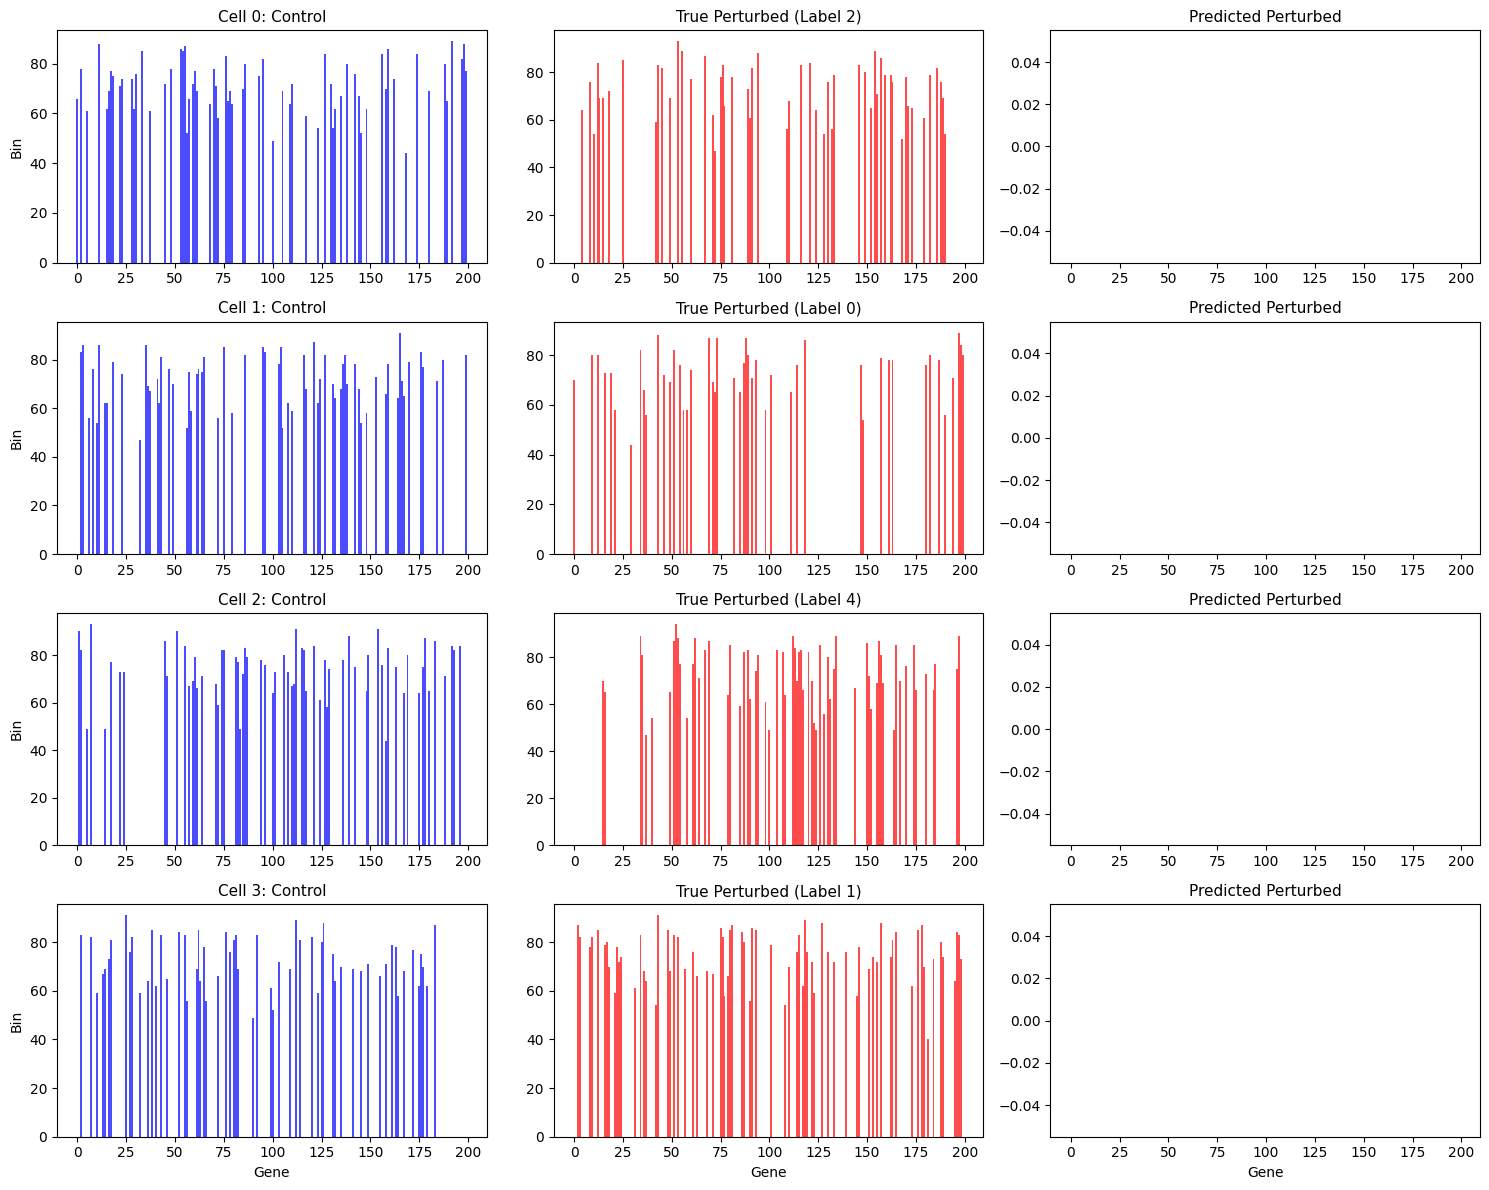

In [ ]:
# Compare predictions for multiple cells
num_examples = 4
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 3 * num_examples))

for i in range(num_examples):
    control_cell = test_control[i].cpu().numpy()
    true_cell = test_perturbed[i].cpu().numpy()
    pred_cell = predicted[i].cpu().numpy()
    pert_label = test_pert_labels[i].item()
    
    # Control
    axes[i, 0].bar(range(NUM_GENES), control_cell, alpha=0.7, width=1.0, color='blue')
    axes[i, 0].set_ylabel('Expr', fontsize=10)
    axes[i, 0].set_title(f'Cell {i}: Control', fontsize=11)
    
    # True perturbed
    axes[i, 1].bar(range(NUM_GENES), true_cell, alpha=0.7, width=1.0, color='red')
    axes[i, 1].set_title(f'True Perturbed (Label {pert_label})', fontsize=11)
    
    # Predicted
    axes[i, 2].bar(range(NUM_GENES), pred_cell, alpha=0.7, width=1.0, color='green')
    axes[i, 2].set_title(f'Predicted Perturbed', fontsize=11)
    
    if i == num_examples - 1:
        axes[i, 0].set_xlabel('Gene', fontsize=10)
        axes[i, 1].set_xlabel('Gene', fontsize=10)
        axes[i, 2].set_xlabel('Gene', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Analyze Perturbation-Specific Performance

Let's see how well the model predicts different perturbations.

In [ ]:
# Calculate metrics per perturbation
pert_metrics = {}

with torch.no_grad():
    for pert_idx in range(NUM_PERTURBATIONS):
        mask = (test_pert_labels == pert_idx)
        if mask.sum() == 0:
            continue
        
        true_vals = test_perturbed[mask]
        pred_vals = predicted[mask]
        
        acc = (true_vals == pred_vals).float().mean().item()
        mae = (true_vals - pred_vals).abs().float().mean().item()
        within_5 = ((true_vals - pred_vals).abs() <= 5).float().mean().item()
        
        pert_metrics[pert_idx] = {
            'accuracy': acc,
            'mae': mae,
            'within_5': within_5,
            'num_cells': mask.sum().item()
        }

# Display metrics
print('Per-perturbation metrics:\n')
for pert_idx, metrics in pert_metrics.items():
    print(f'Perturbation {pert_idx}:')
    print(f'  Cells: {metrics["num_cells"]}')
    print(f'  Accuracy: {metrics["accuracy"]:.2%}')
    print(f'  MAE: {metrics["mae"]:.2f}')
    print(f'  Within 5: {metrics["within_5"]:.2%}')
    print()

Per-perturbation metrics:

Perturbation 0:
  Cells: 4
  Accuracy: 72.25%
  MAE: 20.65
  Within 5 bins: 72.25%

Perturbation 1:
  Cells: 9
  Accuracy: 70.89%
  MAE: 21.60
  Within 5 bins: 70.89%

Perturbation 2:
  Cells: 7
  Accuracy: 71.29%
  MAE: 21.22
  Within 5 bins: 71.29%

Perturbation 3:
  Cells: 5
  Accuracy: 70.70%
  MAE: 21.94
  Within 5 bins: 70.70%

Perturbation 4:
  Cells: 7
  Accuracy: 71.43%
  MAE: 21.23
  Within 5 bins: 71.43%



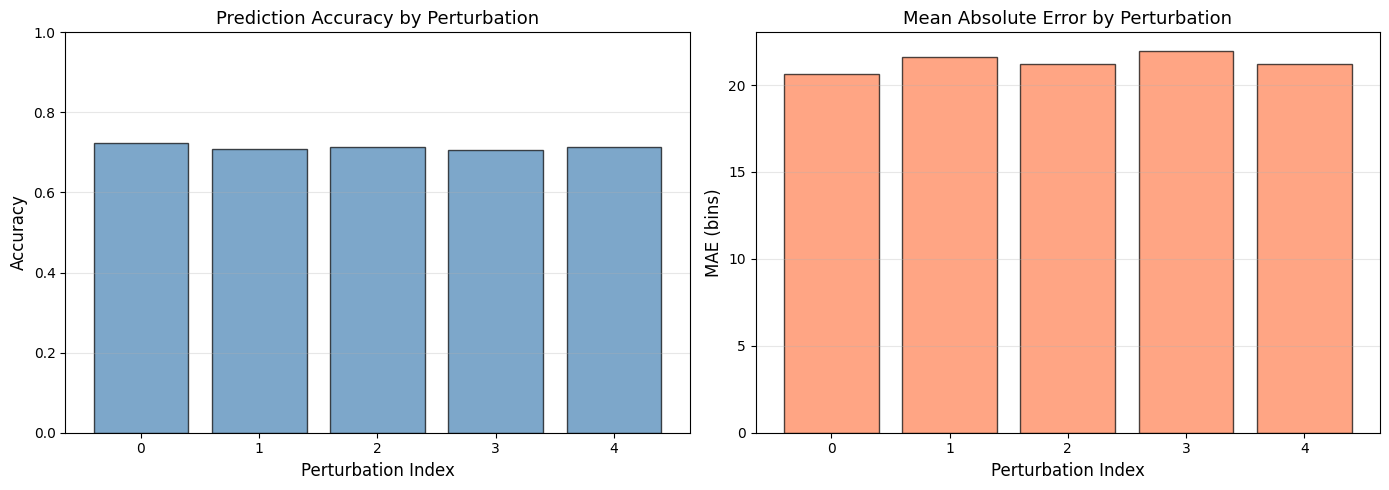

In [ ]:
# Visualize per-perturbation performance
if pert_metrics:
    pert_indices = list(pert_metrics.keys())
    accuracies = [pert_metrics[i]['accuracy'] for i in pert_indices]
    maes = [pert_metrics[i]['mae'] for i in pert_indices]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].bar(pert_indices, accuracies, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Perturbation Index', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Prediction Accuracy by Perturbation', fontsize=13)
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # MAE
    axes[1].bar(pert_indices, maes, alpha=0.7, color='coral', edgecolor='black')
    axes[1].set_xlabel('Perturbation Index', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Mean Absolute Error by Perturbation', fontsize=13)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 8. Save and Load Model

Save the trained model for later use.

In [ ]:
import os

# Create checkpoints directory
os.makedirs('checkpoints', exist_ok=True)

# Save model
trainer.save_checkpoint('checkpoints/demo_perturbseq_model.pt')
print('Model saved to checkpoints/demo_perturbseq_model.pt')

Model saved to checkpoints/demo_perturbseq_model.pt


In [ ]:
# Load model (demonstration)
new_model = SEDDPerturbationTransformerSmall(
    num_genes=NUM_GENES,
    num_bins=NUM_BINS,
    num_perturbations=NUM_PERTURBATIONS,
    hidden_dim=128,
    num_layers=4,
    num_heads=4,
    dropout=0.1
).to(device)

new_trainer = PerturbationTrainer(
    model=new_model,
    graph=graph,
    noise=noise,
    device=device
)

new_trainer.load_checkpoint('checkpoints/demo_perturbseq_model.pt')
print(f'Model loaded! Trained for {new_trainer.epoch + 1} epochs.')
print(f'Best validation loss: {new_trainer.best_loss:.4f}')